In [ ]:
# Data Wrangling
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
!pip install varclushi
from varclushi import VarClusHi
from google.colab import drive
from sklearn.feature_selection import SelectKBest, f_regression

# Enviroment setup
pd.set_option('display.float_format', lambda x: "{:,.5f}".format(x))
pd.set_option('display.max_columns', None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 756.2 kB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Funciones

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

def tipo_consumo(gb):

    if gb < 30:
        r = 'bajo'
    elif gb < 60:
        r = 'medio'
    elif gb < 90:
        r = 'alto'
    else:
        r = 'na'

    return r

def freq(df, var):
    if type(var) != list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().to_frame().rename(columns={v: 'Frecuencia Absoluta'})
        aux['Frecuencia Relativa'] = aux['Frecuencia Absoluta'] / aux['Frecuencia Absoluta'].sum()
        aux[['Frecuencia Absoluta Acumulada','Frecuencia Relativa Acumulada']] = aux.apply( np.cumsum )
        print(f'Tabla de frecuencias para la variable {v} \n')
        display(aux)



def discretizar(df, v, k):

    kb = KBinsDiscretizer( n_bins=k , encode='ordinal', strategy='quantile' )
    kb.fit(df[[v]])
    df[f'd_{v}_{k}'] = pd.cut( df[v], bins= kb.bin_edges_[0] , include_lowest=True  ).astype(str)

    return df






def metricas(model,Xv,yv):
    print(" Métricas para modelo de clasificación: \n")

    print(" Valor ROC : %.3f"   %roc_auc_score( y_score=model.predict_proba(Xv)[:,1] , y_true=yv  )   )

    print(" Valor ACC : %.3f\n" %accuracy_score( y_pred=model.predict(Xv) , y_true=yv) )

    print(" Matriz de confusión: ", "\n", confusion_matrix(y_pred=model.predict(Xv) , y_true=yv ) )


def norm(df, v, umbral):
    aux = df[v].value_counts(normalize=True).reset_index()
    aux.rename(columns={v: 'proportion', 'index': v}, inplace=True)

    aux[f'n_{v}'] = np.where(aux['proportion'] < umbral, 'CAT_PEQUEÑAS', aux[v])
    valor = aux.head(1)[f'n_{v}'].values[0]

    if aux.loc[aux[f'n_{v}'] == 'CAT_PEQUEÑAS']['proportion'].sum() < umbral:
        aux[f'n_{v}'].replace({'CAT_PEQUEÑAS': valor}, inplace=True)

    df = df.merge(aux[[v, f'n_{v}']], on=v, how='left')
    df[f'n_{v}'].fillna(df[v], inplace=True)
    df.drop(v, axis=1, inplace=True)

    return df

def calculo_iv(df, v, tgt , um):
    aux = df.pivot_table( index = v ,
                          columns = tgt ,
                          values = um ,
                         aggfunc = 'count',
                         fill_value = 0 )
    aux[list(range(2))] = aux/aux.apply(np.sum)
    aux['w'] = np.log( aux[0] / aux[1] )
    aux['iv'] = ( aux[0] - aux[1] ) * aux['w']

    return v, aux['iv'].sum()


def calculo_iv2(df, v, tgt, um):
    aux = df.pivot_table(index=v,
                         columns=tgt,
                         values=um,
                         aggfunc='count',
                         fill_value=0)

    aux = aux / aux.apply(np.sum)
    aux = aux[[0, 1]]

    aux['w'] = np.log(aux[0] / aux[1])
    aux['iv'] = (aux[0] - aux[1]) * aux['w']
    print(v, aux['iv'].sum())

    return v, aux['iv'].sum()

# Data Wrangling

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Diplomado/Módulo_2/Prácticas/Datos/heart.csv')

In [ ]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.30000,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.50000,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.40000,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.80000,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.60000,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.20000,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.20000,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.40000,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.20000,1,1,3,0


In [ ]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000
mean,54.36634,0.68317,0.96700,131.62376,246.26403,0.14851,0.52805,149.64686,0.32673,1.03960,1.39934,0.72937,2.31353,0.54455
std,9.08210,0.46601,1.03205,17.53814,51.83075,0.35620,0.52586,22.90516,0.46979,1.16108,0.61623,1.02261,0.61228,0.49883
min,29.00000,0.00000,0.00000,94.00000,126.00000,0.00000,0.00000,71.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,47.50000,0.00000,0.00000,120.00000,211.00000,0.00000,0.00000,133.50000,0.00000,0.00000,1.00000,0.00000,2.00000,0.00000
50%,55.00000,1.00000,1.00000,130.00000,240.00000,0.00000,1.00000,153.00000,0.00000,0.80000,1.00000,0.00000,2.00000,1.00000
75%,61.00000,1.00000,2.00000,140.00000,274.50000,0.00000,1.00000,166.00000,1.00000,1.60000,2.00000,1.00000,3.00000,1.00000
max,77.00000,1.00000,3.00000,200.00000,564.00000,1.00000,2.00000,202.00000,1.00000,6.20000,2.00000,4.00000,3.00000,1.00000


In [ ]:
df['um'] = range(1, len(df) + 1)

In [ ]:
ls_disc = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
ls_cont = ['age','trestbps','chol','thalach','oldpeak']
target = 'target'
um = ['um']

# Ingeniería de Datos

In [ ]:
def createVariables(df):
  df['bp_high'] = (df['trestbps'] > 140).astype(int)
  df['chol_age_ratio'] = df['chol'] / df['age']
  df['relative_physical_activity'] = df['thalach'] / df['age']
  df['significant_cp'] = (df['cp'] > 2).astype(int)
  df['symptom_presence'] = ((df['exang'] == 1) | (df['fbs'] == 1)).astype(int)
  df['relative_st_depression'] = df['oldpeak'] / df['age']
  df['heart_rate_recovery'] = df['thalach'] - 100
  df['combined_risk_score'] = (df['cp'] + df['exang'] + df['ca'] + df['thal'] + df['bp_high'] + df['restecg']) / 6
  return df

In [ ]:
df = createVariables(df)

In [ ]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,um,bp_high,chol_age_ratio,relative_physical_activity,significant_cp,symptom_presence,relative_st_depression,heart_rate_recovery,combined_risk_score
0,63,1,3,145,233,1,0,150,0,2.30000,0,0,1,1,1,1,3.69841,2.38095,1,1,0.03651,50,0.83333
1,37,1,2,130,250,0,1,187,0,3.50000,0,0,2,1,2,0,6.75676,5.05405,0,0,0.09459,87,0.83333
2,41,0,1,130,204,0,0,172,0,1.40000,2,0,2,1,3,0,4.97561,4.19512,0,0,0.03415,72,0.50000
3,56,1,1,120,236,0,1,178,0,0.80000,2,0,2,1,4,0,4.21429,3.17857,0,0,0.01429,78,0.66667
4,57,0,0,120,354,0,1,163,1,0.60000,2,0,2,1,5,0,6.21053,2.85965,0,1,0.01053,63,0.66667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.20000,1,0,3,0,299,0,4.22807,2.15789,0,1,0.00351,23,0.83333
299,45,1,3,110,264,0,1,132,0,1.20000,1,0,3,0,300,0,5.86667,2.93333,1,0,0.02667,32,1.16667
300,68,1,0,144,193,1,1,141,0,3.40000,1,2,3,0,301,1,2.83824,2.07353,0,1,0.05000,41,1.16667
301,57,1,0,130,131,0,1,115,1,1.20000,1,1,3,0,302,0,2.29825,2.01754,0,1,0.02105,15,1.00000


In [ ]:
ls_cont = ls_cont + ['chol_age_ratio','relative_physical_activity','relative_st_depression','heart_rate_recovery','combined_risk_score']
ls_disc = ls_disc + ['bp_high','significant_cp','symptom_presence']

In [ ]:
for var in ls_disc:
  freq(df,var)

Tabla de frecuencias para la variable sex 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
1,207,0.68317,207,0.68317
0,96,0.31683,303,1.00000


Tabla de frecuencias para la variable cp 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,143,0.47195,143,0.47195
2,87,0.28713,230,0.75908
1,50,0.16502,280,0.92409
3,23,0.07591,303,1.00000


Tabla de frecuencias para la variable fbs 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,258,0.85149,258,0.85149
1,45,0.14851,303,1.00000


Tabla de frecuencias para la variable restecg 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
1,152,0.50165,152,0.50165
0,147,0.48515,299,0.98680
2,4,0.01320,303,1.00000


Tabla de frecuencias para la variable exang 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,204,0.67327,204,0.67327
1,99,0.32673,303,1.00000


Tabla de frecuencias para la variable slope 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
2,142,0.46865,142,0.46865
1,140,0.46205,282,0.93069
0,21,0.06931,303,1.00000


Tabla de frecuencias para la variable ca 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,175,0.57756,175,0.57756
1,65,0.21452,240,0.79208
2,38,0.12541,278,0.91749
3,20,0.06601,298,0.98350
4,5,0.01650,303,1.00000


Tabla de frecuencias para la variable thal 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
2,166,0.54785,166,0.54785
3,117,0.38614,283,0.93399
1,18,0.05941,301,0.99340
0,2,0.00660,303,1.00000


Tabla de frecuencias para la variable bp_high 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,238,0.78548,238,0.78548
1,65,0.21452,303,1.00000


Tabla de frecuencias para la variable significant_cp 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,280,0.92409,280,0.92409
1,23,0.07591,303,1.00000


Tabla de frecuencias para la variable symptom_presence 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,175,0.57756,175,0.57756
1,128,0.42244,303,1.00000


In [ ]:
for v in ls_disc:
    df = norm( df , v , 0.03)

In [ ]:
var_n = [col for col in df.columns if col.startswith('n_')]
for var in var_n:
  freq(df,var)

Tabla de frecuencias para la variable n_sex 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
1,207,0.68317,207,0.68317
0,96,0.31683,303,1.00000


Tabla de frecuencias para la variable n_cp 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,143,0.47195,143,0.47195
2,87,0.28713,230,0.75908
1,50,0.16502,280,0.92409
3,23,0.07591,303,1.00000


Tabla de frecuencias para la variable n_fbs 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,258,0.85149,258,0.85149
1,45,0.14851,303,1.00000


Tabla de frecuencias para la variable n_restecg 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
1,156,0.51485,156,0.51485
0,147,0.48515,303,1.00000


Tabla de frecuencias para la variable n_exang 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,204,0.67327,204,0.67327
1,99,0.32673,303,1.00000


Tabla de frecuencias para la variable n_slope 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
2,142,0.46865,142,0.46865
1,140,0.46205,282,0.93069
0,21,0.06931,303,1.00000


Tabla de frecuencias para la variable n_ca 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,180,0.59406,180,0.59406
1,65,0.21452,245,0.80858
2,38,0.12541,283,0.93399
3,20,0.06601,303,1.00000


Tabla de frecuencias para la variable n_thal 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
2,168,0.55446,168,0.55446
3,117,0.38614,285,0.94059
1,18,0.05941,303,1.00000


Tabla de frecuencias para la variable n_bp_high 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,238,0.78548,238,0.78548
1,65,0.21452,303,1.00000


Tabla de frecuencias para la variable n_significant_cp 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,280,0.92409,280,0.92409
1,23,0.07591,303,1.00000


Tabla de frecuencias para la variable n_symptom_presence 



,Frecuencia Absoluta,Frecuencia Relativa,Frecuencia Absoluta Acumulada,Frecuencia Relativa Acumulada
0,175,0.57756,175,0.57756
1,128,0.42244,303,1.00000


# Limpieza de Datos

In [ ]:
df[ls_cont].describe(percentiles=[0.01, 0.02, 0.05, 0.95,0.80, 0.99])

,age,trestbps,chol,thalach,oldpeak,chol_age_ratio,relative_physical_activity,relative_st_depression,heart_rate_recovery,combined_risk_score
count,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000,303.00000
mean,54.36634,131.62376,246.26403,149.64686,1.03960,4.63009,2.87020,0.01886,49.64686,0.84653
std,9.08210,17.53814,51.83075,22.90516,1.16108,1.10455,0.83279,0.02136,22.90516,0.27060
min,29.00000,94.00000,126.00000,71.00000,0.00000,2.09859,1.05970,0.00000,-29.00000,0.33333
1%,35.00000,100.00000,149.00000,95.02000,0.00000,2.48784,1.52667,0.00000,-4.98000,0.33333
2%,35.08000,101.04000,160.16000,97.08000,0.00000,2.72138,1.56581,0.00000,-2.92000,0.33333
5%,39.10000,108.00000,175.00000,108.10000,0.00000,3.08452,1.71144,0.00000,8.10000,0.50000
50%,55.00000,130.00000,240.00000,153.00000,0.80000,4.47727,2.77049,0.01343,53.00000,0.83333
80%,62.00000,144.00000,285.20000,170.00000,1.90000,5.48816,3.47787,0.03444,70.00000,1.10000
95%,68.00000,160.00000,326.90000,181.90000,3.40000,6.58548,4.44890,0.05923,81.90000,1.33333


## Missings

In [ ]:
df.isna().mean()

age                          0.00000
trestbps                     0.00000
chol                         0.00000
thalach                      0.00000
oldpeak                      0.00000
target                       0.00000
um                           0.00000
chol_age_ratio               0.00000
relative_physical_activity   0.00000
relative_st_depression       0.00000
heart_rate_recovery          0.00000
combined_risk_score          0.00000
n_sex                        0.00000
n_cp                         0.00000
n_fbs                        0.00000
n_restecg                    0.00000
n_exang                      0.00000
n_slope                      0.00000
n_ca                         0.00000
n_thal                       0.00000
n_bp_high                    0.00000
n_significant_cp             0.00000
n_symptom_presence           0.00000
dtype: float64

## Unarias

In [ ]:
df.nunique()

age                            41
trestbps                       49
chol                          152
thalach                        91
oldpeak                        40
target                          2
um                            303
chol_age_ratio                292
relative_physical_activity    285
relative_st_depression        172
heart_rate_recovery            91
combined_risk_score             8
n_sex                           2
n_cp                            4
n_fbs                           2
n_restecg                       2
n_exang                         2
n_slope                         3
n_ca                            4
n_thal                          3
n_bp_high                       2
n_significant_cp                2
n_symptom_presence              2
dtype: int64

In [ ]:
unarias = [c for c, conteo in zip( var_n , [df[v].unique().shape[0] for v in var_n ] ) if conteo == 1 ]

In [ ]:
unarias

[]

## Multicolinealidad

In [ ]:
vc =  VarClusHi( df=df[ls_cont] , feat_list = ls_cont )

In [ ]:
vc.varclus()

In [ ]:
rs = vc.rsquare
rs = rs.sort_values( by = ['Cluster','RS_Ratio'] ,ascending=[1,1] ).reset_index(drop=True)
rs['id'] = rs.groupby('Cluster').cumcount() + 1
rs

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio,id
0,0,thalach,1.00000,0.32476,0.00000,1
1,0,heart_rate_recovery,1.00000,0.32476,0.00000,2
2,1,relative_st_depression,0.98785,0.08577,0.01328,1
3,1,oldpeak,0.98785,0.11846,0.01378,2
4,2,trestbps,0.65094,0.05047,0.36761,1
5,2,combined_risk_score,0.55627,0.04601,0.46513,2
6,2,chol,0.11434,0.00560,0.89065,3
7,3,age,0.86695,0.15882,0.15817,1
8,3,relative_physical_activity,0.83772,0.61163,0.41784,2
9,3,chol_age_ratio,0.57291,0.07777,0.46311,3


In [ ]:
ls_cont2 = rs.loc[ rs['id'] == 1 ]['Variable'].tolist()
#ls_cont2 = ls_cont

## Discretizar

In [ ]:
for v in ls_cont:
    for k in range(2,7):
        df = discretizar(df, v, k)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279

In [ ]:
vari = [col for col in df.columns if col.startswith('d_')]

In [ ]:
len(vari) , vari

(50,
 ['d_age_2',
  'd_age_3',
  'd_age_4',
  'd_age_5',
  'd_age_6',
  'd_trestbps_2',
  'd_trestbps_3',
  'd_trestbps_4',
  'd_trestbps_5',
  'd_trestbps_6',
  'd_chol_2',
  'd_chol_3',
  'd_chol_4',
  'd_chol_5',
  'd_chol_6',
  'd_thalach_2',
  'd_thalach_3',
  'd_thalach_4',
  'd_thalach_5',
  'd_thalach_6',
  'd_oldpeak_2',
  'd_oldpeak_3',
  'd_oldpeak_4',
  'd_oldpeak_5',
  'd_oldpeak_6',
  'd_chol_age_ratio_2',
  'd_chol_age_ratio_3',
  'd_chol_age_ratio_4',
  'd_chol_age_ratio_5',
  'd_chol_age_ratio_6',
  'd_relative_physical_activity_2',
  'd_relative_physical_activity_3',
  'd_relative_physical_activity_4',
  'd_relative_physical_activity_5',
  'd_relative_physical_activity_6',
  'd_relative_st_depression_2',
  'd_relative_st_depression_3',
  'd_relative_st_depression_4',
  'd_relative_st_depression_5',
  'd_relative_st_depression_6',
  'd_heart_rate_recovery_2',
  'd_heart_rate_recovery_3',
  'd_heart_rate_recovery_4',
  'd_heart_rate_recovery_5',
  'd_heart_rate_recovery

In [ ]:
X = df[ls_cont].copy()

In [ ]:
X = df[um + vari + var_n]
y = df[um + [target]]

In [ ]:
iv = pd.DataFrame(map(lambda v: calculo_iv(df, v, target, um), vari), columns=['variable', 'iv'])

In [ ]:
iv['raiz'] = iv['variable'].map( lambda x: '_'.join( x.split('_')[1:-1] ) )
iv = iv.sort_values( by=['raiz','iv'] , ascending=[1,0] ).reset_index(drop=True)
iv['id'] = iv.groupby( 'raiz' ).cumcount()+1
iv = iv.loc[iv['id']==1]

In [ ]:
iv

,variable,iv,raiz,id
0,d_age_6,0.41273,age,1
5,d_chol_6,0.10886,chol,1
10,d_chol_age_ratio_5,0.09631,chol_age_ratio,1
15,d_combined_risk_score_6,0.27809,combined_risk_score,1
20,d_heart_rate_recovery_5,0.87416,heart_rate_recovery,1
25,d_oldpeak_6,0.92663,oldpeak,1
30,d_relative_physical_activity_6,0.89585,relative_physical_activity,1
35,d_relative_st_depression_6,0.86957,relative_st_depression,1
40,d_thalach_5,0.87416,thalach,1
45,d_trestbps_5,0.11872,trestbps,1


In [ ]:
besti = iv['variable'].tolist()

In [ ]:
ivn = pd.DataFrame( map( lambda v:  calculo_iv( df , v , target , um  ) , var_n  ) , columns=['variable','iv']  )

In [ ]:
iv = pd.concat([iv,ivn], ignore_index=True)

In [ ]:
iv = iv[['variable','iv']].sort_values(by=['iv'],ascending=False).reset_index(drop=True)

In [ ]:
iv

,variable,iv
0,n_thal,1.24943
1,n_cp,1.21013
2,n_ca,1.10691
3,d_oldpeak_6,0.92663
4,d_relative_physical_activity_6,0.89585
5,d_heart_rate_recovery_5,0.87416
6,d_thalach_5,0.87416
7,d_relative_st_depression_6,0.86957
8,n_exang,0.83251
9,n_slope,0.67495


In [ ]:
best = iv.loc[ (iv.iv >= 0.03) ]['variable'].tolist()

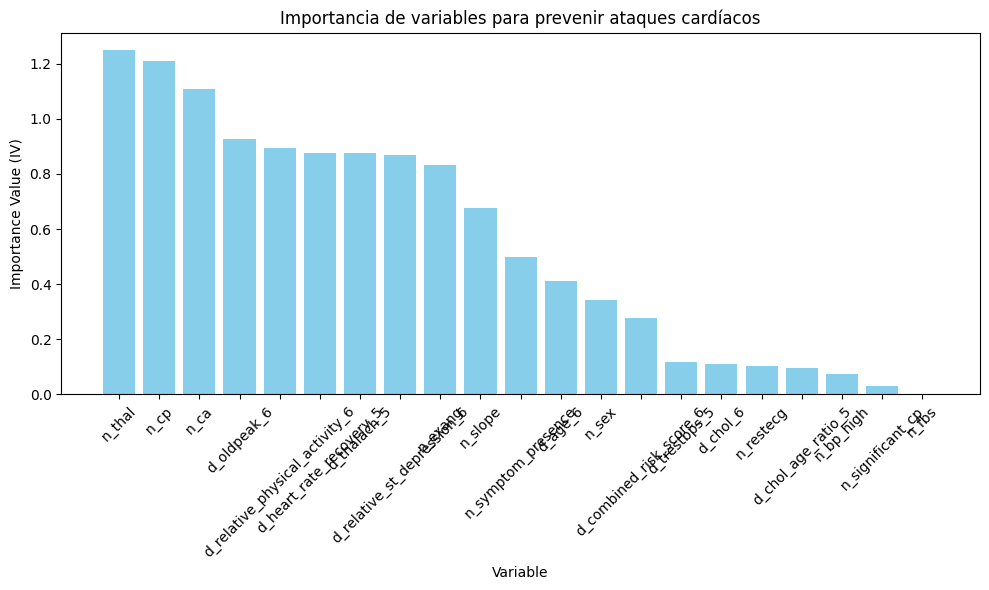

In [ ]:


# Datos del DataFrame
variables = iv['variable']
iv_values = iv['iv']

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(variables, iv_values, color='skyblue')

# Títulos y etiquetas
plt.title('Importancia de variables para prevenir ataques cardíacos')
plt.xlabel('Variable')
plt.ylabel('Importance Value (IV)')
plt.xticks(rotation=45)  # Rotar las etiquetas para mejorar la legibilidad

# Mostrar gráfico
plt.tight_layout()
plt.show()


In [ ]:
len(best) , best

(20,
 ['n_thal',
  'n_cp',
  'n_ca',
  'd_oldpeak_6',
  'd_relative_physical_activity_6',
  'd_heart_rate_recovery_5',
  'd_thalach_5',
  'd_relative_st_depression_6',
  'n_exang',
  'n_slope',
  'n_symptom_presence',
  'd_age_6',
  'n_sex',
  'd_combined_risk_score_6',
  'd_trestbps_5',
  'd_chol_6',
  'n_restecg',
  'd_chol_age_ratio_5',
  'n_bp_high',
  'n_significant_cp'])

In [ ]:
X[best]

,n_thal,n_cp,n_ca,d_oldpeak_6,d_relative_physical_activity_6,d_heart_rate_recovery_5,d_thalach_5,d_relative_st_depression_6,n_exang,n_slope,n_symptom_presence,d_age_6,n_sex,d_combined_risk_score_6,d_trestbps_5,d_chol_6,n_restecg,d_chol_age_ratio_5,n_bp_high,n_significant_cp
0,1,3,0,"(2.0, 6.2]","(2.117, 2.415]","(46.0, 59.0]","(146.0, 159.0]","(0.0233, 0.0379]",0,0,1,"(59.0, 63.667]",1,"(0.667, 0.833]","(144.0, 200.0]","(221.667, 240.0]",0,"(2.0980000000000003, 3.726]",1,1
1,2,2,0,"(2.0, 6.2]","(3.694, 6.966]","(70.0, 102.0]","(170.0, 202.0]","(0.0379, 0.102]",0,0,0,"(28.999, 44.0]",1,"(0.667, 0.833]","(126.0, 134.0]","(240.0, 263.0]",1,"(5.488, 8.418]",0,0
2,2,1,0,"(0.8, 1.4]","(3.694, 6.966]","(70.0, 102.0]","(170.0, 202.0]","(0.0233, 0.0379]",0,2,0,"(28.999, 44.0]",0,"(0.332, 0.556]","(126.0, 134.0]","(200.333, 221.667]",0,"(4.879, 5.488]",0,0
3,2,1,0,"(0.1, 0.8]","(3.07, 3.694]","(70.0, 102.0]","(170.0, 202.0]","(0.0134, 0.0233]",0,2,0,"(55.0, 59.0]",1,"(0.556, 0.667]","(93.999, 120.0]","(221.667, 240.0]",1,"(3.726, 4.227]",0,0
4,2,0,0,"(0.1, 0.8]","(2.77, 3.07]","(59.0, 70.0]","(159.0, 170.0]","(0.00165, 0.0134]",1,2,1,"(55.0, 59.0]",0,"(0.556, 0.667]","(93.999, 120.0]","(294.0, 564.0]",1,"(5.488, 8.418]",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,3,0,0,"(0.1, 0.8]","(2.117, 2.415]","(-29.001, 30.0]","(70.999, 130.0]","(0.00165, 0.0134]",1,1,1,"(55.0, 59.0]",0,"(0.667, 0.833]","(134.0, 144.0]","(240.0, 263.0]",1,"(4.227, 4.879]",0,0
299,3,3,0,"(0.8, 1.4]","(2.77, 3.07]","(30.0, 46.0]","(130.0, 146.0]","(0.0233, 0.0379]",0,1,0,"(44.0, 51.0]",1,"(1.0, 1.167]","(93.999, 120.0]","(263.0, 294.0]",1,"(5.488, 8.418]",0,1
300,3,0,2,"(2.0, 6.2]","(1.0590000000000002, 2.117]","(30.0, 46.0]","(130.0, 146.0]","(0.0379, 0.102]",0,1,1,"(63.667, 77.0]",1,"(1.0, 1.167]","(134.0, 144.0]","(125.999, 200.333]",1,"(2.0980000000000003, 3.726]",1,0
301,3,0,1,"(0.8, 1.4]","(1.0590000000000002, 2.117]","(-29.001, 30.0]","(70.999, 130.0]","(0.0134, 0.0233]",1,1,1,"(55.0, 59.0]",1,"(0.833, 1.0]","(126.0, 134.0]","(125.999, 200.333]",1,"(2.0980000000000003, 3.726]",0,0


## Transformación WoE

In [ ]:
X = X[um + best].reset_index(drop=True)
X.shape , y.shape

((303, 21), (303, 2))

In [ ]:
def codificacion_woe(df, v, tgt, um):
    aux = df.pivot_table(index=v,
                         columns=tgt,
                         values=um,
                         aggfunc='count',
                         fill_value=0)
    aux[list(range(2))] = aux / aux.apply(np.sum)

    aux['w'] = np.log(aux[0] / aux[1])
    display(aux)
    aux.drop(range(2), axis=1, inplace=True)

    aux_dict = aux['w'].to_dict()

    return v, aux_dict


In [ ]:
mapa_woe = list( map( lambda v: codificacion_woe( df, v , target , um ) , best )  )

um            0       1        w
target   0    1                         
n_thal                                  
1       12    6 0.08696 0.03636  0.87184
2       37  131 0.26812 0.79394 -1.08559
3       89   28 0.64493 0.16970  1.33512

um           0       1        w
target    0   1                         
n_cp                                    
0       104  39 0.75362 0.23636  1.15952
1         9  41 0.06522 0.24848 -1.33766
2        18  69 0.13043 0.41818 -1.16504
3         7  16 0.05072 0.09697 -0.64799

um            0       1        w
target   0    1                         
n_ca                                    
0       46  134 0.33333 0.81212 -0.89051
1       44   21 0.31884 0.12727  0.91836
2       31    7 0.22464 0.04242  1.66677
3       17    3 0.12319 0.01818  1.91329

um           0       1        w
target          0   1                         
d_oldpeak_6                                   
(-0.001, 0.1]  28  78 0.20290 0.47273 -0.84581
(0.1, 0.8]     16  41 0.11594 0.24848 -0.76229
(0.8, 1.4]     29  21 0.21014 0.12727  0.50147
(1.4, 2.0]     22  18 0.15942 0.10909  0.37936
(2.0, 6.2]     43   7 0.31159 0.04242  1.99398

um           0       1        w
target                           0   1                         
d_relative_physical_activity_6                                 
(1.0590000000000002, 2.117]     36  15 0.26087 0.09091  1.05416
(2.117, 2.415]                  30  20 0.21739 0.12121  0.58416
(2.415, 2.77]                   34  17 0.24638 0.10303  0.87184
(2.77, 3.07]                    14  36 0.10145 0.21818 -0.76577
(3.07, 3.694]                   18  32 0.13043 0.19394 -0.39667
(3.694, 6.966]                   6  45 0.04348 0.27273 -1.83621

um           0       1        w
target                    0   1                         
d_heart_rate_recovery_5                                 
(-29.001, 30.0]          47  16 0.34058 0.09697  1.25625
(30.0, 46.0]             39  20 0.28261 0.12121  0.84652
(46.0, 59.0]             23  39 0.16667 0.23636 -0.34938
(59.0, 70.0]             20  41 0.14493 0.24848 -0.53915
(70.0, 102.0]             9  49 0.06522 0.29697 -1.51590

um           0       1        w
target            0   1                         
d_thalach_5                                     
(130.0, 146.0]   39  20 0.28261 0.12121  0.84652
(146.0, 159.0]   23  39 0.16667 0.23636 -0.34938
(159.0, 170.0]   20  41 0.14493 0.24848 -0.53915
(170.0, 202.0]    9  49 0.06522 0.29697 -1.51590
(70.999, 130.0]  47  16 0.34058 0.09697  1.25625

um           0       1        w
target                       0   1                         
d_relative_st_depression_6                                 
(-0.001, 0.00165]           26  75 0.18841 0.45455 -0.88070
(0.00165, 0.0134]           14  37 0.10145 0.22424 -0.79317
(0.0134, 0.0233]            28  22 0.20290 0.13333  0.41985
(0.0233, 0.0379]            27  23 0.19565 0.13939  0.33903
(0.0379, 0.102]             43   8 0.31159 0.04848  1.86045

um            0       1        w
target    0    1                         
n_exang                                  
0        62  142 0.44928 0.86061 -0.65000
1        76   23 0.55072 0.13939  1.37393

um            0       1        w
target    0    1                         
n_slope                                  
0        12    9 0.08696 0.05455  0.46637
1        91   49 0.65942 0.29697  0.79773
2        35  107 0.25362 0.64848 -0.93879

um            0       1        w
target               0    1                         
n_symptom_presence                                  
0                   54  121 0.39130 0.73333 -0.62811
1                   84   44 0.60870 0.26667  0.82532

um           0       1        w
target           0   1                         
d_age_6                                        
(28.999, 44.0]  14  42 0.10145 0.25455 -0.91992
(44.0, 51.0]    18  33 0.13043 0.20000 -0.42744
(51.0, 55.0]    17  28 0.12319 0.16970 -0.32030
(55.0, 59.0]    37  24 0.26812 0.14545  0.61156
(59.0, 63.667]  28  11 0.20290 0.06667  1.11300
(63.667, 77.0]  24  27 0.17391 0.16364  0.06091

um           0       1        w
target    0   1                         
n_sex                                   
0        24  72 0.17391 0.43636 -0.91992
1       114  93 0.82609 0.56364  0.38229

um           0       1        w
target                    0   1                         
d_combined_risk_score_6                                 
(0.332, 0.556]           13  38 0.09420 0.23030 -0.89395
(0.556, 0.667]           24  39 0.17391 0.23636 -0.30682
(0.667, 0.833]           33  42 0.23913 0.25455 -0.06247
(0.833, 1.0]             33  20 0.23913 0.12121  0.67947
(1.0, 1.167]             24  15 0.17391 0.09091  0.64870
(1.167, 1.5]             11  11 0.07971 0.06667  0.17869

um           0       1        w
target            0   1                         
d_trestbps_5                                    
(120.0, 126.0]   15  10 0.10870 0.06061  0.58416
(126.0, 134.0]   27  35 0.19565 0.21212 -0.08082
(134.0, 144.0]   24  35 0.17391 0.21212 -0.19860
(144.0, 200.0]   35  25 0.25362 0.15152  0.51516
(93.999, 120.0]  37  60 0.26812 0.36364 -0.30473

um           0       1        w
target               0   1                         
d_chol_6                                           
(125.999, 200.333]  21  30 0.15217 0.18182 -0.17798
(200.333, 221.667]  17  33 0.12319 0.20000 -0.48460
(221.667, 240.0]    21  30 0.15217 0.18182 -0.17798
(240.0, 263.0]      25  26 0.18116 0.15758  0.13947
(263.0, 294.0]      30  20 0.21739 0.12121  0.58416
(294.0, 564.0]      24  26 0.17391 0.15758  0.09865

um           0       1        w
target      0   1                         
n_restecg                                 
0          79  68 0.57246 0.41212  0.32863
1          59  97 0.42754 0.58788 -0.31848

um           0       1        w
target                        0   1                         
d_chol_age_ratio_5                                          
(2.0980000000000003, 3.726]  27  34 0.19565 0.20606 -0.05183
(3.726, 4.227]               35  25 0.25362 0.15152  0.51516
(4.227, 4.879]               30  31 0.21739 0.18788  0.14590
(4.879, 5.488]               22  38 0.15942 0.23030 -0.36785
(5.488, 8.418]               24  37 0.17391 0.22424 -0.25417

um            0       1        w
target       0    1                         
n_bp_high                                   
0          100  138 0.72464 0.83636 -0.14339
1           38   27 0.27536 0.16364  0.52044

um            0       1        w
target              0    1                         
n_significant_cp                                   
0                 131  149 0.94928 0.90303  0.04994
1                   7   16 0.05072 0.09697 -0.64799

In [ ]:
mapa_woe

[('n_thal',
  {'1': 0.8718389693033212,
   '2': -1.0855876218135512,
   '3': 1.3351236483003117}),
 ('n_cp',
  {'0': 1.159521041755102,
   '1': -1.3376557006247125,
   '2': -1.1650429579577186,
   '3': -0.6479867844410919}),
 ('n_ca',
  {'0': -0.8905066147184405,
   '1': 0.9183589849382142,
   '2': 1.6667688441732087,
   '3': 1.9132928441314823}),
 ('d_oldpeak_6',
  {'(-0.001, 0.1]': -0.8458125277710119,
   '(0.1, 0.8]': -0.7622915557211506,
   '(0.8, 1.4]': 0.501465181006427,
   '(1.4, 2.0]': 0.3793624842055271,
   '(2.0, 6.2]': 1.993981755381625}),
 ('d_relative_physical_activity_6',
  {'(1.0590000000000002, 2.117]': 1.0541605260972757,
   '(2.117, 2.415]': 0.5841568968515403,
   '(2.415, 2.77]': 0.8718389693033212,
   '(2.77, 3.07]': -0.7657698200974753,
   '(3.07, 3.694]': -0.396672356160186,
   '(3.694, 6.966]': -1.8362112317988888}),
 ('d_heart_rate_recovery_5',
  {'(-29.001, 30.0]': 1.2562506682136534,
   '(30.0, 46.0]': 0.8465211613190313,
   '(46.0, 59.0]': -0.3493756414571209

In [ ]:
for v, mapa in mapa_woe:
    df[f'w_{v}'] = df[v].replace(mapa)

In [ ]:
varw = df.filter(like='w_').columns.tolist()

In [ ]:
df.head()

,age,trestbps,chol,thalach,oldpeak,target,um,chol_age_ratio,relative_physical_activity,relative_st_depression,heart_rate_recovery,combined_risk_score,n_sex,n_cp,n_fbs,n_restecg,n_exang,n_slope,n_ca,n_thal,n_bp_high,n_significant_cp,n_symptom_presence,d_age_2,d_age_3,d_age_4,d_age_5,d_age_6,d_trestbps_2,d_trestbps_3,d_trestbps_4,d_trestbps_5,d_trestbps_6,d_chol_2,d_chol_3,d_chol_4,d_chol_5,d_chol_6,d_thalach_2,d_thalach_3,d_thalach_4,d_thalach_5,d_thalach_6,d_oldpeak_2,d_oldpeak_3,d_oldpeak_4,d_oldpeak_5,d_oldpeak_6,d_chol_age_ratio_2,d_chol_age_ratio_3,d_chol_age_ratio_4,d_chol_age_ratio_5,d_chol_age_ratio_6,d_relative_physical_activity_2,d_relative_physical_activity_3,d_relative_physical_activity_4,d_relative_physical_activity_5,d_relative_physical_activity_6,d_relative_st_depression_2,d_relative_st_depression_3,d_relative_st_depression_4,d_relative_st_depression_5,d_relative_st_depression_6,d_heart_rate_recovery_2,d_heart_rate_recovery_3,d_heart_rate_recovery_4,d_heart_rate_recovery_5,d_heart_rate_recovery_6,d_combined_risk_score_2,d_combined_risk_score_3,d_combined_risk_score_4,d_combined_risk_score_5,d_combined_risk_score_6,w_n_thal,w_n_cp,w_n_ca,w_d_oldpeak_6,w_d_relative_physical_activity_6,w_d_heart_rate_recovery_5,w_d_thalach_5,w_d_relative_st_depression_6,w_n_exang,w_n_slope,w_n_symptom_presence,w_d_age_6,w_n_sex,w_d_combined_risk_score_6,w_d_trestbps_5,w_d_chol_6,w_n_restecg,w_d_chol_age_ratio_5,w_n_bp_high,w_n_significant_cp
0,63,145,233,150,2.30000,1,1,3.69841,2.38095,0.03651,50,0.83333,1,3,1,0,0,0,0,1,1,1,1,"(55.0, 77.0]","(59.0, 77.0]","(61.0, 77.0]","(62.0, 77.0]","(59.0, 63.667]","(130.0, 200.0]","(138.0, 200.0]","(140.0, 200.0]","(144.0, 200.0]","(138.0, 149.333]","(125.999, 240.0]","(221.667, 263.0]","(211.0, 240.0]","(230.0, 254.0]","(221.667, 240.0]","(70.999, 153.0]","(143.0, 162.0]","(133.5, 153.0]","(146.0, 159.0]","(143.0, 153.0]","(0.8, 6.2]","(1.4, 6.2]","(1.6, 6.2]","(1.9, 6.2]","(2.0, 6.2]","(2.0980000000000003, 4.477]","(2.0980000000000003, 4.031]","(2.0980000000000003, 3.836]","(2.0980000000000003, 3.726]","(3.606, 4.031]","(1.0590000000000002, 2.77]","(1.0590000000000002, 2.415]","(2.284, 2.77]","(2.193, 2.566]","(2.117, 2.415]","(0.0134, 0.102]","(0.0233, 0.102]","(0.0296, 0.102]","(0.0344, 0.102]","(0.0233, 0.0379]","(-29.001, 53.0]","(43.0, 62.0]","(33.5, 53.0]","(46.0, 59.0]","(43.0, 53.0]","(0.332, 0.833]","(0.667, 1.0]","(0.667, 0.833]","(0.667, 0.833]","(0.667, 0.833]",0.87184,-0.64799,-0.89051,1.99398,0.58416,-0.34938,-0.34938,0.33903,-0.65000,0.46637,0.82532,1.11300,0.38229,-0.06247,0.51516,-0.17798,0.32863,-0.05183,0.52044,-0.64799
1,37,130,250,187,3.50000,1,2,6.75676,5.05405,0.09459,87,0.83333,1,2,0,1,0,0,0,2,0,0,0,"(28.999, 55.0]","(28.999, 51.0]","(28.999, 47.5]","(28.999, 45.0]","(28.999, 44.0]","(93.999, 130.0]","(122.667, 138.0]","(120.0, 130.0]","(126.0, 134.0]","(122.667, 130.0]","(240.0, 564.0]","(221.667, 263.0]","(240.0, 274.5]","(230.0, 254.0]","(240.0, 263.0]","(153.0, 202.0]","(162.0, 202.0]","(166.0, 202.0]","(170.0, 202.0]","(172.0, 202.0]","(0.8, 6.2]","(1.4, 6.2]","(1.6, 6.2]","(1.9, 6.2]","(2.0, 6.2]","(4.477, 8.418]","(5.04, 8.418]","(5.306, 8.418]","(5.488, 8.418]","(5.652, 8.418]","(2.77, 6.966]","(3.07, 6.966]","(3.27, 6.966]","(3.478, 6.966]","(3.694, 6.966]","(0.0134, 0.102]","(0.0233, 0.102]","(0.0296, 0.102]","(0.0344, 0.102]","(0.0379, 0.102]","(53.0, 102.0]","(62.0, 102.0]","(66.0, 102.0]","(70.0, 102.0]","(72.0, 102.0]","(0.332, 0.833]","(0.667, 1.0]","(0.667, 0.833]","(0.667, 0.833]","(0.667, 0.833]",-1.08559,-1.16504,-0.89051,1.99398,-1.83621,-1.51590,-1.51590,1.86045,-0.65000,0.46637,-0.62811,-0.91992,0.38229,-0.06247,-0.08082,0.13947,-0.31848,-0.25417,-0.14339,0.04994
2,41,130,204,172,1.40000,1,3,4.97561,4.19512,0.03415,72,0.50000,0,1,0,0,0,2,0,2,0,0,0,"(28.999, 55.0]","(28.999, 51.0]","(28.999, 47.5]","(28.999, 45.0]","(28.999, 44.0]","(93.999, 130.0]","(122.667, 138.0]","(120.0, 130.0]","(126.0, 134.0]","(122.667, 130.0]","(125.999, 240.0]","(125.999,

# Modelo

In [ ]:
tad = df[varw].copy()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
pipe = Pipeline([("imputador", SimpleImputer(strategy="median")),
                 ("modelo", LogisticRegression())])

In [ ]:
y = df[target]

In [ ]:
pipe.fit(tad, y)

Pipeline(steps=[('imputador', SimpleImputer(strategy='median')),
                ('modelo', LogisticRegression())])

In [ ]:
ls_scores = cross_val_score(X=tad, y=y, cv=4, n_jobs=-1, estimator=pipe, scoring="roc_auc")

In [ ]:
ls_scores.mean(), ls_scores.std()

(0.9215822914531666, 0.01849502825695461)

# Hyperparametrización

In [ ]:
pipe2 = Pipeline([("imputador", SimpleImputer(strategy="median")),
                 ("modelo", LogisticRegression())])

In [ ]:
param_grid = {
    'imputador__strategy': ['mean', 'median', 'most_frequent'],
    'modelo__C': [0.001, 0.01,0.05, 0.1, 1, 10, 100, 1000],
    'modelo__penalty': ['l1', 'l2'],
    'modelo__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'modelo__max_iter': [5,10,50, 100, 200],
    'modelo__class_weight': [None, 'balanced'],
    'modelo__random_state': [42],
    'modelo__multi_class': ['ovr', 'multinomial']
}
#grid_search = GridSearchCV(pipe2, param_grid, cv=4, scoring='accuracy')
#grid_search.fit(tad, y)

In [ ]:
#grid_search.best_params_

In [ ]:
pipe2 = Pipeline([
    ('imputador', SimpleImputer(strategy='median')),
    ('modelo', LogisticRegression(C=0.1,
                                  class_weight= 'balanced',
                                  penalty='l2',
                                  random_state= 42,
                                  solver= 'newton-cg',
                                  multi_class= 'multinomial',
                                  max_iter= 5))
])

In [ ]:
ls_scores = cross_val_score(X=tad, y=y, cv=4, n_jobs=-1, estimator=pipe2, scoring="roc_auc")

In [ ]:
ls_scores.mean(), ls_scores.std()

(0.9215874154539865, 0.02068836953229095)

# Credit scoring

In [ ]:
logreg = LogisticRegression()

In [ ]:
logreg.fit(tad, y)

LogisticRegression()

In [ ]:
PDO = 20
base_score = 200
base_odds = 2

In [ ]:
factor =  PDO / np.log(2)
offset = base_score - factor * np.log( base_odds )

In [ ]:
print(factor,offset)

28.85390081777927 180.0


In [ ]:
betas = logreg.coef_[0].tolist()
beta0 = logreg.intercept_[0]

In [ ]:
n = len(betas)

In [ ]:
for v, beta in zip(varw, betas):

    print(v,beta)
    df[f'pts_{v}'] = np.ceil( (-df[v] * beta+beta0 / n) * factor + offset / n )

w_n_thal -0.5187274637985057
w_n_cp -0.6724144959617374
w_n_ca -0.9084904010445938
w_d_oldpeak_6 0.0036039578340509803
w_d_relative_physical_activity_6 -0.20965517017511756
w_d_heart_rate_recovery_5 -0.028323527718819574
w_d_thalach_5 -0.028323527718819574
w_d_relative_st_depression_6 -0.548302948659523
w_n_exang -0.8037606485665705
w_n_slope -0.4806794101353623
w_n_symptom_presence 0.6484746166203962
w_d_age_6 -0.39776166884590575
w_n_sex -1.0088714612362684
w_d_combined_risk_score_6 -0.0930871850251725
w_d_trestbps_5 -0.6337804535079976
w_d_chol_6 -0.8518177145875536
w_n_restecg -0.3613595966583721
w_d_chol_age_ratio_5 0.276032090668115
w_n_bp_high 0.040939565585988325
w_n_significant_cp -0.7106054909621041


In [ ]:
varp = df.filter(like='pts_').columns.tolist()

In [ ]:
df['score'] = df[varp].sum(axis=1)

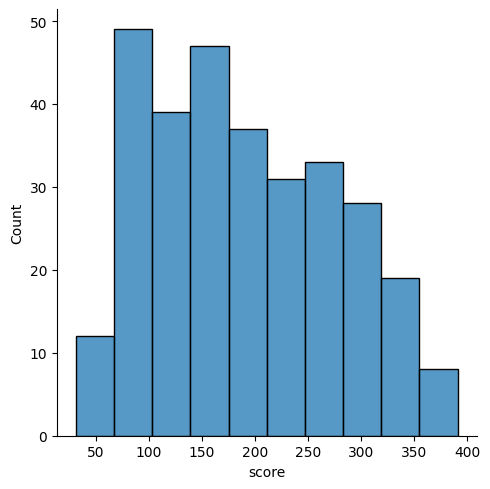

In [ ]:
sns.displot(df['score'])

In [ ]:
lst = []

In [ ]:
for vi, vp in zip( [v[2:] for v in varw] , varp ):

    aux= df[[vi,vp]].drop_duplicates()
    aux = aux.sort_values(  by = vi , ascending= True).reset_index(drop=True)
    aux.columns = ['atributo','puntos']
    aux['caracterísitca'] = vi
    lst.append(aux)

In [ ]:
scorecard = pd.concat( lst , ignore_index=True )

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
scorecard

,atributo,puntos,caracterísitca
0,1,23.00000,n_thal
1,2,-7.00000,n_thal
2,3,30.00000,n_thal
3,0,32.00000,n_cp
4,1,-16.00000,n_cp
5,2,-13.00000,n_cp
6,3,-3.00000,n_cp
7,0,-14.00000,n_ca
8,1,34.00000,n_ca
9,2,53.00000,n_ca


In [ ]:
pd.set_option('display.max_rows', 20)

In [ ]:
df_ordenado = scorecard.sort_values(by='puntos')

In [ ]:
df_ordenado

,atributo,puntos,caracterísitca
50,0,-17.00000,n_sex
4,1,-16.00000,n_cp
7,0,-14.00000,n_ca
5,2,-13.00000,n_cp
1,2,-7.00000,n_thal
...,...,...,...
8,1,34.00000,n_ca
36,"(0.0379, 0.102]",39.00000,d_relative_st_depression_6
38,1,42.00000,n_exang
9,2,53.00000,n_ca


In [ ]:
df

,age,trestbps,chol,thalach,oldpeak,target,um,chol_age_ratio,relative_physical_activity,relative_st_depression,heart_rate_recovery,combined_risk_score,n_sex,n_cp,n_fbs,n_restecg,n_exang,n_slope,n_ca,n_thal,n_bp_high,n_significant_cp,n_symptom_presence,d_age_2,d_age_3,d_age_4,d_age_5,d_age_6,d_trestbps_2,d_trestbps_3,d_trestbps_4,d_trestbps_5,d_trestbps_6,d_chol_2,d_chol_3,d_chol_4,d_chol_5,d_chol_6,d_thalach_2,d_thalach_3,d_thalach_4,d_thalach_5,d_thalach_6,d_oldpeak_2,d_oldpeak_3,d_oldpeak_4,d_oldpeak_5,d_oldpeak_6,d_chol_age_ratio_2,d_chol_age_ratio_3,d_chol_age_ratio_4,d_chol_age_ratio_5,d_chol_age_ratio_6,d_relative_physical_activity_2,d_relative_physical_activity_3,d_relative_physical_activity_4,d_relative_physical_activity_5,d_relative_physical_activity_6,d_relative_st_depression_2,d_relative_st_depression_3,d_relative_st_depression_4,d_relative_st_depression_5,d_relative_st_depression_6,d_heart_rate_recovery_2,d_heart_rate_recovery_3,d_heart_rate_recovery_4,d_heart_rate_recovery_5,d_heart_rate_recovery_6,d_combined_risk_score_2,d_combined_risk_score_3,d_combined_risk_score_4,d_combined_risk_score_5,d_combined_risk_score_6,w_n_thal,w_n_cp,w_n_ca,w_d_oldpeak_6,w_d_relative_physical_activity_6,w_d_heart_rate_recovery_5,w_d_thalach_5,w_d_relative_st_depression_6,w_n_exang,w_n_slope,w_n_symptom_presence,w_d_age_6,w_n_sex,w_d_combined_risk_score_6,w_d_trestbps_5,w_d_chol_6,w_n_restecg,w_d_chol_age_ratio_5,w_n_bp_high,w_n_significant_cp,pts_w_n_thal,pts_w_n_cp,pts_w_n_ca,pts_w_d_oldpeak_6,pts_w_d_relative_physical_activity_6,pts_w_d_heart_rate_recovery_5,pts_w_d_thalach_5,pts_w_d_relative_st_depression_6,pts_w_n_exang,pts_w_n_slope,pts_w_n_symptom_presence,pts_w_d_age_6,pts_w_n_sex,pts_w_d_combined_risk_score_6,pts_w_d_trestbps_5,pts_w_d_chol_6,pts_w_n_restecg,pts_w_d_chol_age_ratio_5,pts_w_n_bp_high,pts_w_n_significant_cp,score
0,63,145,233,150,2.30000,1,1,3.69841,2.38095,0.03651,50,0.83333,1,3,1,0,0,0,0,1,1,1,1,"(55.0, 77.0]","(59.0, 77.0]","(61.0, 77.0]","(62.0, 77.0]","(59.0, 63.667]","(130.0, 200.0]","(138.0, 200.0]","(140.0, 200.0]","(144.0, 200.0]","(138.0, 149.333]","(125.999, 240.0]","(221.667, 263.0]","(211.0, 240.0]","(230.0, 254.0]","(221.667, 240.0]","(70.999, 153.0]","(143.0, 162.0]","(133.5, 153.0]","(146.0, 159.0]","(143.0, 153.0]","(0.8, 6.2]","(1.4, 6.2]","(1.6, 6.2]","(1.9, 6.2]","(2.0, 6.2]","(2.0980000000000003, 4.477]","(2.0980000000000003, 4.031]","(2.0980000000000003, 3.836]","(2.0980000000000003, 3.726]","(3.606, 4.031]","(1.0590000000000002, 2.77]","(1.0590000000000002, 2.415]","(2.284, 2.77]","(2.193, 2.566]","(2.117, 2.415]","(0.0134, 0.102]","(0.0233, 0.102]","(0.0296, 0.102]","(0.0344, 0.102]","(0.0233, 0.0379]","(-29.001, 53.0]","(43.0, 62.0]","(33.5, 53.0]","(46.0, 59.0]","(43.0, 53.0]","(0.332, 0.833]","(0.667, 1.0]","(0.667, 0.833]","(0.667, 0.833]","(0.667, 0.833]",0.87184,-0.64799,-0.89051,1.99398,0.58416,-0.34938,-0.34938,0.33903,-0.65000,0.46637,0.82532,1.11300,0.38229,-0.06247,0.51516,-0.17798,0.32863,-0.05183,0.52044,-0.64799,23.00000,-3.00000,-14.00000,9.00000,13.00000,9.00000,9.00000,15.00000,-5.00000,16.00000,-6.00000,22.00000,21.00000,9.00000,19.00000,5.00000,13.00000,10.00000,9.00000,-4.00000,170.00000
1,37,130,250,187,3.50000,1,2,6.75676,5.05405,0.09459,87,0.83333,1,2,0,1,0,0,0,2,0,0,0,"(28.999, 55.0]","(28.999, 51.0]","(28.999, 47.5]","(28.999, 45.0]","(28.999, 44.0]","(93.999, 130.0]","(122.667, 138.0]","(120.0, 130.0]","(126.0, 134.0]","(122.667, 130.0]","(240.0, 564.0]","(221.667, 263.0]","(240.0, 274.5]","(230.0, 254.0]","(240.0, 263.0]","(153.0, 202.0]","(162.0, 202.0]","(166.0, 202.0]","(170.0, 202.0]","(172.0, 202.0]","(0.8, 6.2]","(1.4, 6.2]","(1.6, 6.2]","(1.9, 6.2]","(2.0, 6.2]","(4.477, 8.418]","(5.04, 8.418]","(5.306, 8.418]","(5.488, 8.418]","(5.652, 8.418]","(2.77, 6.966]","(3.07, 6.966]","(3.27, 6.966]","(3.478, 6.966]","(3.694, 6.966]","(0.0134, 0.102]","(0.0233, 0.102]","(0.0296, 0.102]","(0.0344, 0.102]","(0.0379, 0.102]","(53.0, 102.0]","(62.0, 102.0]","(66.0, 10

In [ ]:
min_score_target_1 = df[df['target'] == 1]['score'].mean()

max_score_target_0 = df[df['target'] == 0]['score'].mean()

(min_score_target_1, max_score_target_0)

(129.4060606060606, 262.04347826086956)

In [ ]:
((max_score_target_0 - min_score_target_1)/2)+min_score_target_1

195.7247694334651